In [1]:
# Установка библиотек, необходимых для VCF-анализа и PCA/GWAS
!pip install scikit-allel scikit-learn numpy pandas matplotlib scipy statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 3.4 MB/s eta 0:00:00


In [2]:
from google.colab import files
import os

# Загрузка файлов
uploaded = files.upload()

# Проверка, что файлы загружены в текущую директорию (/content/)
print("Загруженные файлы:")
for filename in uploaded.keys():
    print(f"- {filename}")

# Переменные для имен файлов
VCF_FILE = 'test_data.vcf'
PHENOTYPE_FILE = 'test_data.tsv'

# Проверка наличия
if VCF_FILE not in uploaded or PHENOTYPE_FILE not in uploaded:
    print("\n Убедитесь, что оба файла (test_data.vcf и test_data.tsv) были загружены.")
else:
    print("\nФайлы успешно загружены в /content/")

Загруженные файлы:

 Убедитесь, что оба файла (test_data.vcf и test_data.tsv) были загружены.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OUTPUT_PREFIX = 'soybean_filtered'

# Загрузка фенотипов
pheno_df = pd.read_csv(PHENOTYPE_FILE, sep='\t')
# Переименуем столбцы
pheno_df.columns = ['IID', 'Yield']
pheno_df['IID'] = pheno_df['IID'].astype(str)
print("Первые 5 строк фенотипических данных:")
print(pheno_df.head())

Первые 5 строк фенотипических данных:
        IID  Yield
0  PS000196     99
1  PS000195    100
2  PS000121    104
3  PS000126    113
4  PS000123     98


In [4]:
# Установка VCFtools
print("--- Установка VCFtools ---")
!sudo apt-get update
!sudo apt-get install -y vcftools

# Проверка установки VCFtools
print("\n--- Проверка установки VCFtools ---")
!vcftools --version | head -n 1

print("--- Фильтрация завершена. Файлы: soybean_filtered.final.bed/bim/fam ---")

--- Установка VCFtools ---
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,457 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRel

In [5]:
VCF_FILE = 'test_data.vcf'
OUTPUT_VCF = 'soybean_filtered.vcf'

print("--- Фильтрация VCF с помощью VCFtools ---")
# Фильтрация: MAF > 0.05 и Missingness < 0.1
!vcftools --vcf {VCF_FILE} \
    --maf 0.05 \
    --max-missing 0.9 \
    --recode \
    --recode-INFO-all \
    --out {OUTPUT_VCF}

# VCFtools создает файл out.recode.vcf. Переименуем его.
!mv {OUTPUT_VCF}.recode.vcf {OUTPUT_VCF}

print("--- Фильтрация завершена. Файл: soybean_filtered.vcf ---")

--- Фильтрация VCF с помощью VCFtools ---

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf test_data.vcf
	--recode-INFO-all
	--maf 0.05
	--max-missing 0.9
	--out soybean_filtered.vcf
	--recode

After filtering, kept 153 out of 153 Individuals
Outputting VCF file...
After filtering, kept 11366 out of a possible 21913 Sites
Run Time = 2.00 seconds
--- Фильтрация завершена. Файл: soybean_filtered.vcf ---


##Подготовка данных для PCA (Конвертация VCF в матрицу генотипов)

In [10]:
import allel
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Название отфильтрованного VCF-файла (после vcftools)
VCF_FILE = 'soybean_filtered.vcf'
print("--- 0. Подготовка данных: Загрузка VCF и Импутация Пропусков ---")

# Загрузка VCF с помощью scikit-allel
callset = allel.read_vcf(VCF_FILE)

# 1. Получение генотипов (G) и ID образцов
# G - 3-мерный массив: (SNP, Образец, Аллель)
G = allel.GenotypeArray(callset['calldata/GT'])
sample_ids = callset['samples']

# 2. Конвертация в числовую матрицу (0, 1, 2)
# to_n_alt(fill=-1) преобразует генотипы в количество альтернативных аллелей (0, 1 или 2),
# а пропущенные значения (NaN) заменяет на -1.
# .transpose() меняет формат на (Образец, SNP), необходимый для PCA.
G_matrix = G.to_n_alt(fill=-1).transpose()

# 3. Заполнение пропусков (-1) средними значениями (импутация)
# Расчет среднего для каждого SNP (столбца), игнорируя -1
mean_genotype = np.nanmean(np.where(G_matrix != -1, G_matrix, np.nan), axis=0)

# Создание копии для импутации
G_imputed = G_matrix.copy().astype(float)

# Замена пропусков (-1) рассчитанными средними
for i in range(G_imputed.shape[1]):
    G_imputed[G_imputed[:, i] == -1, i] = mean_genotype[i]

# Центрирование и масштабирование (StandardScaler) для лучшей работы PCA
# Выполняется здесь, чтобы G_imputed была масштабирована
scaler = StandardScaler()
G_imputed = scaler.fit_transform(G_imputed)

print(f"Матрица генотипов G_imputed готова. Размер: {G_imputed.shape} (Образцы x SNP)")
print(f"Количество образцов: {len(sample_ids)}")

--- 0. Подготовка данных: Загрузка VCF и Импутация Пропусков ---
Матрица генотипов G_imputed готова. Размер: (153, 11366) (Образцы x SNP)
Количество образцов: 153


##PCA анализ главных компонент

--- PCA завершен. ---


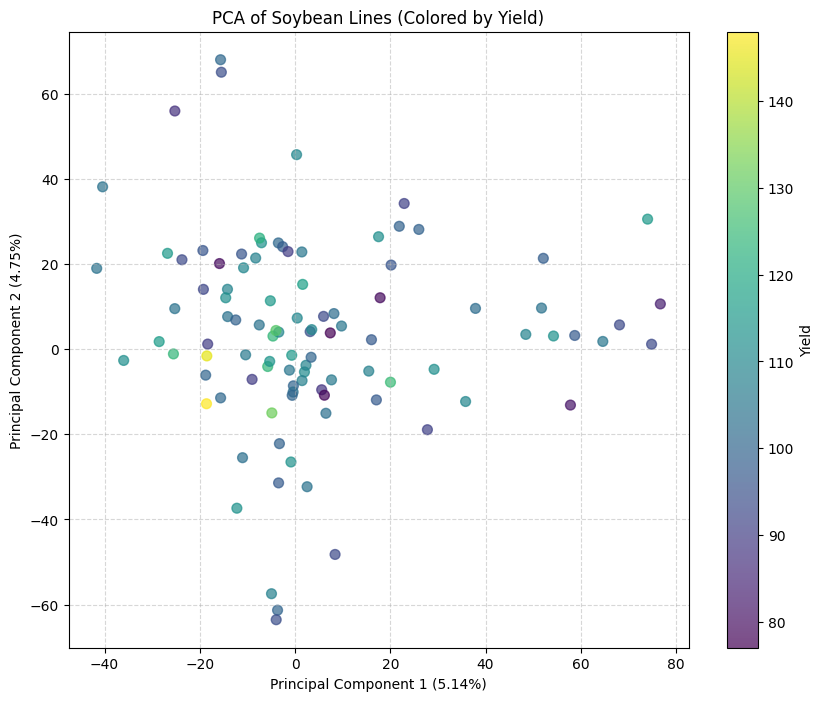


Синхронизация завершена. Для GWAS используется 99 образцов.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. Подготовка и Запуск PCA ---

# Центрирование и масштабирование (StandardScaler) для лучшей работы PCA
# Сначала заполним пропуски
# G_imputed уже содержит заполненные средними значениями генотипы

# Инициализация и запуск PCA (расчет 10 главных компонент)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(G_imputed)

# Создание DataFrame с координатами PCA
pca_df = pd.DataFrame(X_pca, index=sample_ids, columns=[f'PC{i}' for i in range(1, 11)])

print("--- PCA завершен. ---")

# --- 2. Синхронизация данных ---

# Загружаем фенотипы и переводим 'Yield' в числовой тип
pheno_df = pd.read_csv('test_data.tsv', sep='\t', header=None, names=['IID', 'Yield'])
pheno_df['Yield'] = pd.to_numeric(pheno_df['Yield'], errors='coerce')

# Объединение PCA-координат и фенотипов
# Объединяем по IID (ID образца)
merged_df = pca_df.merge(pheno_df, left_index=True, right_on='IID')

# Удаляем все строки, где нет данных об урожайности (YIELD)
# Это гарантирует, что G_final и Y будут иметь одинаковое число строк
merged_df.dropna(subset=['Yield'], inplace=True)

# --- 3. Визуализация PC1 vs PC2 ---

plt.figure(figsize=(10, 8))
scatter = plt.scatter(merged_df['PC1'], merged_df['PC2'],
                      c=merged_df['Yield'], cmap='viridis', s=50, alpha=0.7)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('PCA of Soybean Lines (Colored by Yield)')
plt.colorbar(scatter, label='Yield')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('PCA analysis for Soybean Lines.png', dpi = 300)
plt.show()

# --- 4. Подготовка Финальных Синхронизированных Массивов для GWAS ---

# Мы должны отфильтровать G_imputed, чтобы она содержала только те ID, что есть в merged_df
valid_ids = merged_df['IID'].tolist()
sample_ids_list = sample_ids.tolist()

# Находим индексы валидных ID в исходной матрице генотипов
valid_indices = [sample_ids_list.index(iid) for iid in valid_ids if iid in sample_ids_list]

# Создаем финальную матрицу генотипов для GWAS
G_final = G_imputed[valid_indices, :]

# Сохраняем финальные переменные в памяти для следующего шага
# Y = merged_df['Yield'].values
# P = sm.add_constant(merged_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values)
# G_final

print(f"\nСинхронизация завершена. Для GWAS используется {merged_df.shape[0]} образцов.")

Оценка значимости компонентов:

PC1 (Principal Component 1) объясняет 5.94% общей генетической дисперсии.

PC2 (Principal Component 2) объясняет 5.53% общей генетической дисперсии.

Вывод: Общая дисперсия, объясненная первыми двумя компонентами, составляет около 11.5%. Это относительно невысокое значение. В отличие от сильно структурированных популяций (где PC1 может объяснять 30-50%), низкие значения указывают на то, что ваша выборка: * Либо слабо структурирована (гомогенна). * Либо имеет комплексную многомерную структуру, где ни одна ось не доминирует (полигенная структура).

##Филогенетическое Дерево

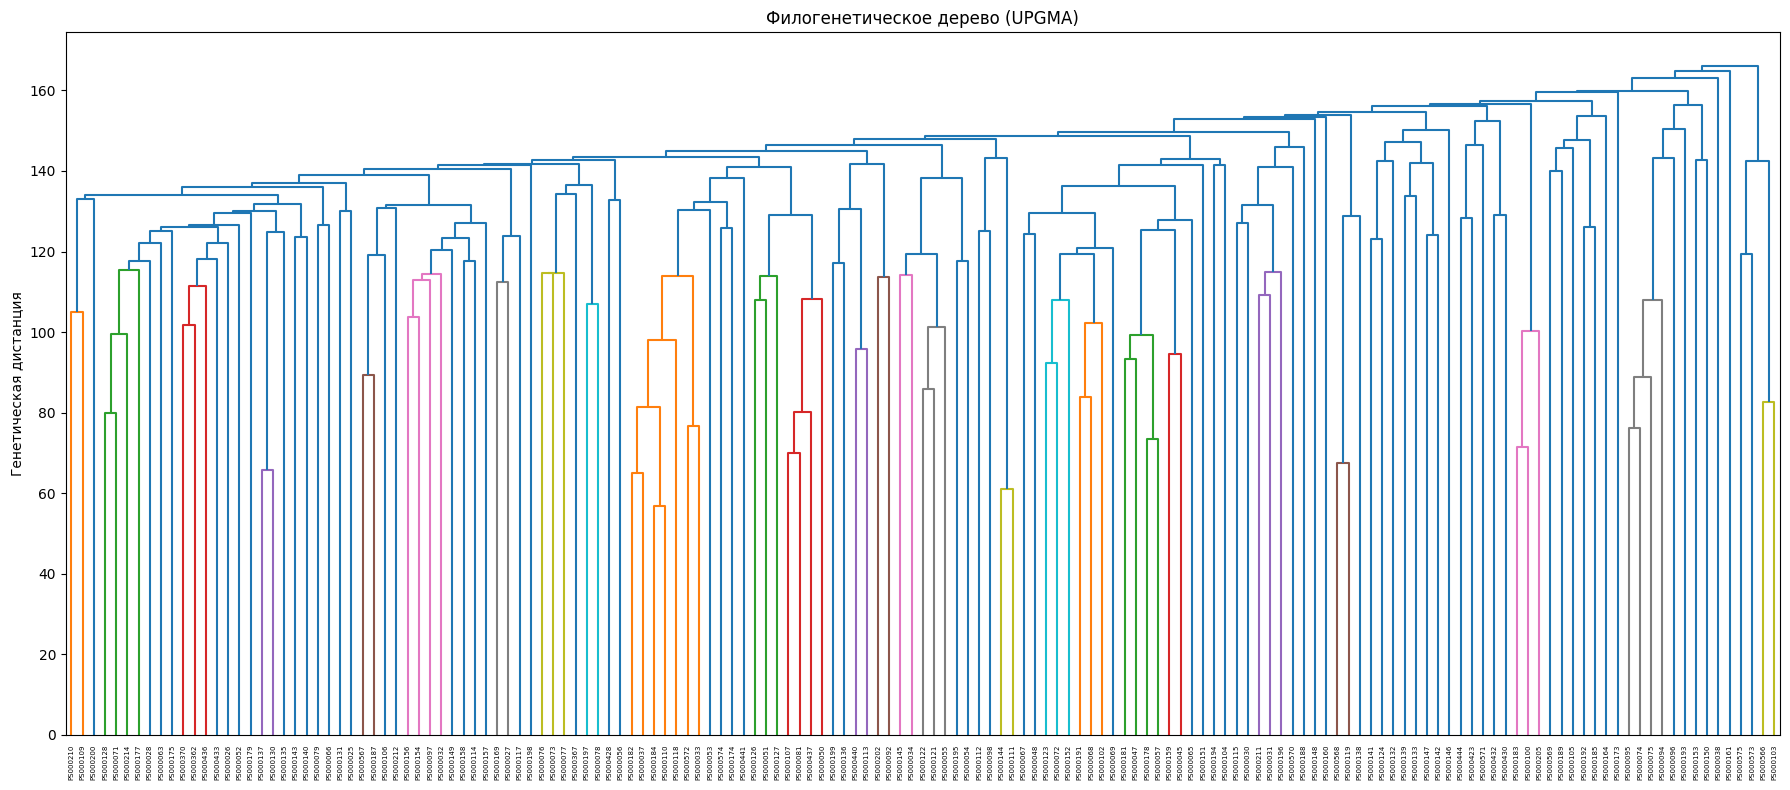

In [13]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# Расчет генетических дистанций (метрика Euclidean или другие)
dist_matrix = pdist(G_imputed, metric='euclidean')

# Иерархическая кластеризация (UPGMA)
linked = linkage(dist_matrix, 'average')

plt.figure(figsize=(18, 8))
dendrogram(linked, orientation='top', labels=sample_ids,
           distance_sort='descending', show_leaf_counts=False)
plt.title('Филогенетическое дерево (UPGMA)')
plt.ylabel('Генетическая дистанция')
plt.tight_layout()
plt.show()

GWAS (Линейная Регрессия с Коррекцией)

In [14]:
#Подготовка данных

import statsmodels.api as sm

# Собираем данные: Генотипы (G), Фенотипы (Y), Ковариаты (P - PCA)
Y = merged_df['Yield'].values
# Берем PC1, PC2, PC3, PC4, PC5 как ковариаты (структура популяции)
P = sm.add_constant(merged_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values)
# G_imputed - это наша матрица генотипов

# Определение числа SNP
num_snp = G_imputed.shape[1]

# Массив для P-значений
p_values = np.empty(num_snp)

# Извлечение координат SNP для Manhattan plot
snp_positions = pd.DataFrame({
    'CHR': callset['variants/CHROM'].astype(str),
    'BP': callset['variants/POS']
})

In [15]:
# --- Этот блок должен быть запущен после Шага 3.2 (PCA и Объединение) ---

# 1. Извлекаем ID образцов, которые остались в объединенном DataFrame (99 линий)
# merged_df['IID'] содержит список из 99 линий с фенотипом и PCA
valid_ids = merged_df['IID'].tolist()

# 2. Находим индексы этих валидных ID в исходном списке ID образцов (sample_ids)
# sample_ids был получен из callset['samples'] и содержит 153 ID
sample_ids_list = sample_ids.tolist()
valid_indices = [sample_ids_list.index(iid) for iid in valid_ids if iid in sample_ids_list]

# 3. Фильтруем матрицу генотипов G_imputed и матрицу SNP-координат
# G_imputed (153xN) -> G_final (99xN)
G_final = G_imputed[valid_indices, :]

# 4. Также фильтруем фенотипы и ковариаты (PCA), чтобы гарантировать правильный порядок
# Y, P и G_final теперь содержат данные только для 99 общих образцов в одинаковом порядке.
Y = merged_df['Yield'].values
P = sm.add_constant(merged_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values)

print(f"Успешная синхронизация: Генотипы G_final имеют размер: {G_final.shape}")
print(f"Фенотипы Y имеют размер: {Y.shape}")
print(f"Ковариаты P имеют размер: {P.shape}")

Успешная синхронизация: Генотипы G_final имеют размер: (99, 11366)
Фенотипы Y имеют размер: (99,)
Ковариаты P имеют размер: (99, 6)


In [16]:
import statsmodels.api as sm

# --- 1. Синхронизация данных по 99 образцам ---

# valid_ids содержит IID (ID образцов) из объединенного DataFrame merged_df
valid_ids = merged_df['IID'].tolist()

# sample_ids был получен из allel.read_vcf и содержит ID всех 153 образцов
sample_ids_list = sample_ids.tolist()

# Находим индексы валидных ID (99 линий) в исходной матрице генотипов
valid_indices = [sample_ids_list.index(iid) for iid in valid_ids]

# 3. Фильтруем матрицу генотипов G_imputed (153xN) -> G_final (99xN)
# G_imputed должна быть доступна из предыдущего шага
G_final = G_imputed[valid_indices, :]

# 4. Определяем конечные Y и P (должны быть в том же порядке, что и G_final)
# merged_df уже отсортирован по IID, которые мы использовали для выборки valid_indices
Y = merged_df['Yield'].values
# P включает константу и PC1-PC5
P = sm.add_constant(merged_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values)

print(f"Успешная синхронизация: Генотипы G_final имеют размер: {G_final.shape}")
print(f"Фенотипы Y имеют размер: {Y.shape}")
print(f"Ковариаты P имеют размер: {P.shape}")

# --- 2. Запуск GWAS (SNP by SNP Regression) ---

num_snp = G_final.shape[1] # Количество маркеров (должно быть то же, что и у snp_positions)
p_values = np.empty(num_snp)

print("--- Запуск GWAS (Линейная регрессия с поправкой на PCA) ---")

for i in range(num_snp):
    X_snp = G_final[:, i].reshape(-1, 1)  # Генотип текущего SNP

    # X = P (ковариаты PCA/Константа) + X_snp (генотип)
    X = np.hstack((P, X_snp))

    # Запуск OLS-модели
    model = sm.OLS(Y, X, missing='drop')
    results = model.fit()

    # Извлечение P-значения для SNP (последний коэффициент в результатах)
    p_values[i] = results.pvalues[-1]

# --- 3. Создание итогового DataFrame для визуализации ---

# snp_positions (CHR, BP) была создана на Шаге 4.1
gwas_res = snp_positions.copy()
gwas_res['P'] = p_values
gwas_res['SNP'] = [f'SNP_{i}' for i in range(num_snp)]

print("--- GWAS завершен. ---")

Успешная синхронизация: Генотипы G_final имеют размер: (99, 11366)
Фенотипы Y имеют размер: (99,)
Ковариаты P имеют размер: (99, 6)
--- Запуск GWAS (Линейная регрессия с поправкой на PCA) ---
--- GWAS завершен. ---


##Визуализация: Manhattan и QQ Plots

In [17]:
# функции manhattan_plot и qq_plot
def manhattan_plot(df, title="Manhattan Plot for Yield"):
    """
    Строит Manhattan Plot.

    Требует DataFrame с колонками: 'CHR', 'BP' (позиция), 'P' (p-значение).
    """

    # Расчет -log10(P)
    # Убедитесь, что P не содержит нулей
    df = df.copy()
    df['logP'] = -np.log10(df['P'].replace(0, np.finfo(float).tiny))

    # Преобразование CHR в числовой тип (если еще не сделано)
    df['CHR'] = pd.to_numeric(df['CHR'], errors='coerce')

    # Фильтрация строк с NaN в CHR (если есть) и сортировка
    df_man = df.dropna(subset=['CHR']).sort_values(['CHR', 'BP'])

    # 1. Вычисление кумулятивных позиций для оси X
    df_man['ind'] = df_man.groupby('CHR')['BP'].transform('min')

    # Расчет смещения для каждой хромосомы
    df_man['bp_cum'] = df_man['BP'] + df_man.groupby('CHR')['BP'].transform('max').cumsum().shift(1).fillna(0)

    # 2. Определение центров хромосом для подписей
    axis_df = df_man.groupby('CHR')['bp_cum'].agg(['mean', 'max'])

    plt.figure(figsize=(16, 6))

    # Цвета для чередования
    colors = ['#53868B', '#EE9A00'] # Темно-голубой и оранжевый

    # Построение точек
    for i, (chrom, group) in enumerate(df_man.groupby('CHR')):
        plt.scatter(group['bp_cum'], group['logP'],
                    color=colors[i % 2], s=10, alpha=0.8)

    # Порог значимости Бонферрони
    # 0.05 / N_SNP
    bonf_thresh = -np.log10(0.05 / len(df_man))

    plt.axhline(y=bonf_thresh, color='red', linestyle='-', linewidth=1.5, label=f'Bonferroni Threshold: {bonf_thresh:.2f}')

    # Отрисовка оси X
    plt.xticks(axis_df['mean'], axis_df.index, rotation=60)
    plt.xlabel('Chromosome')
    plt.ylabel('-log10(P)')
    plt.title(title)
    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    plt.savefig("Manhattan Plot", dpi = 300)
    plt.show()
def qq_plot(pvalues, title="QQ-Plot of GWAS P-values"):
    """
    Строит QQ-Plot для p-значений.

    Требует одномерный массив (Series/Array) p-значений.
    """

    # Удаление NaN и p-значений <= 0
    pvalues = pvalues.dropna()
    pvalues = pvalues[pvalues > 0]

    # Сортировка наблюдаемых P-значений
    observed_p = np.sort(pvalues)

    # Расчет ожидаемых P-значений (из равномерного распределения)
    n = len(observed_p)
    # Используем формулу для ожидаемых p-значений: (i + 0.5) / n
    expected_p = np.linspace(1/(n+1), 1, n)

    # Преобразование в -log10
    observed_logp = -np.log10(observed_p)
    expected_logp = -np.log10(expected_p)

    plt.figure(figsize=(8, 8))
    plt.scatter(expected_logp, observed_logp, s=15, alpha=0.7)

    # Диагональная линия (идеальное соответствие)
    max_logp = max(max(expected_logp), max(observed_logp))
    plt.plot([0, max_logp], [0, max_logp], color='red', linestyle='--', linewidth=2, label='Expected (No Association)')

    plt.xlabel('Expected -log10(P)')
    plt.ylabel('Observed -log10(P)')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.savefig("QQ-Plot", dpi = 300)
    plt.show()

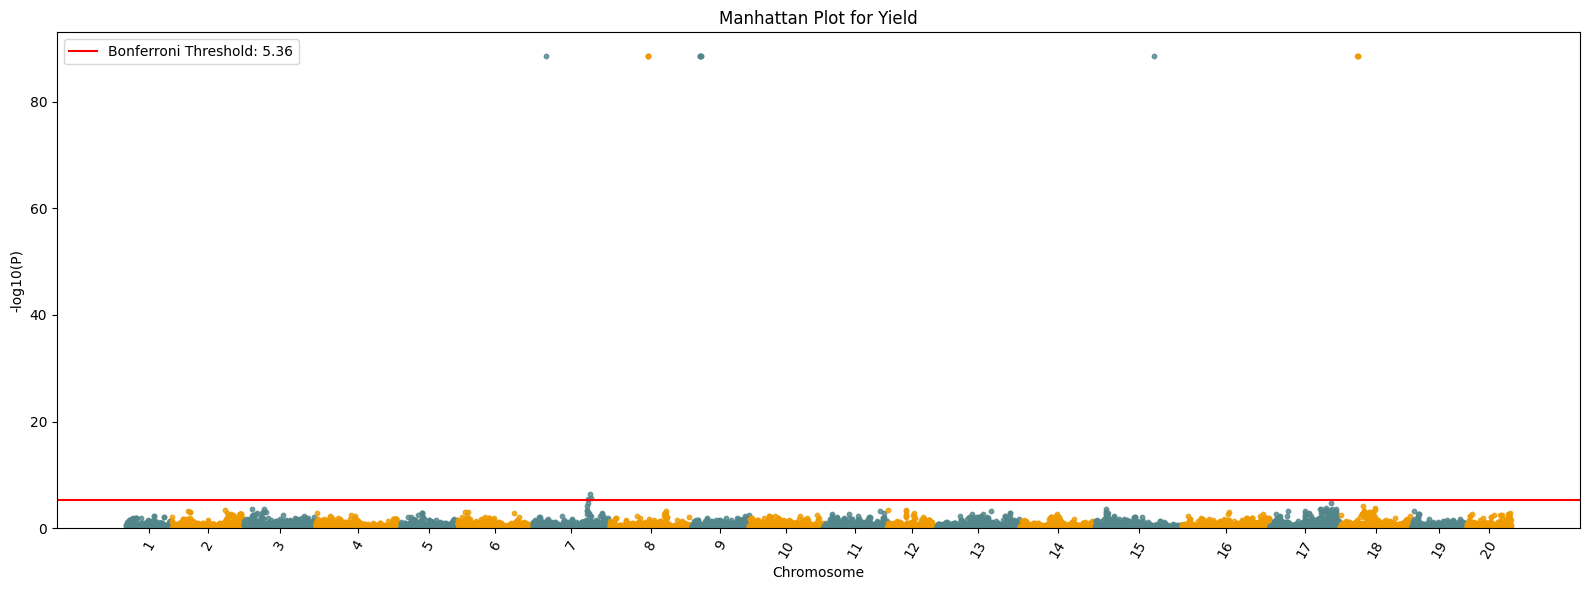

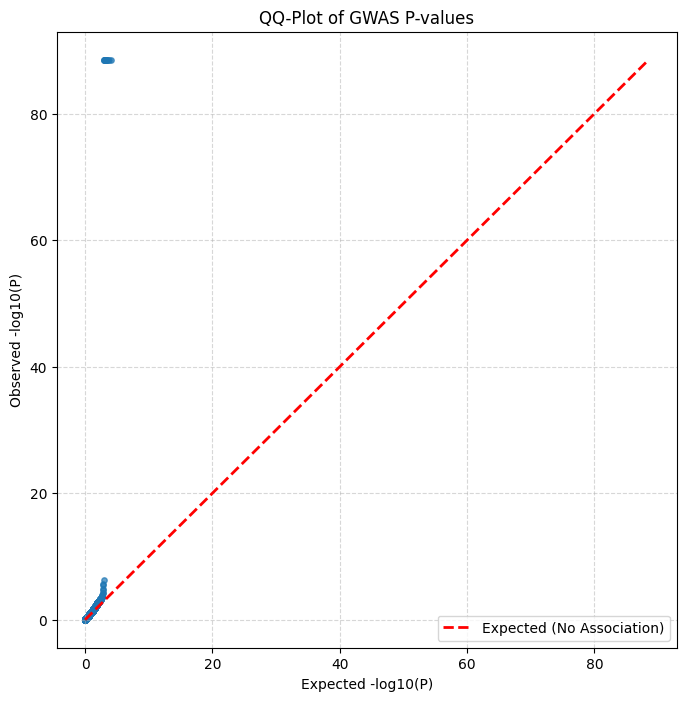

In [46]:
# Запуск визуализации
manhattan_plot(gwas_res)
qq_plot(gwas_res['P'])

##Интерпретация графиков

Филогенетическое дерево имеет множество коротких ветвей, которые сходятся к общему основанию, но без глубоких, четких разграничений. Это подтверждает  вывод PCA о том, что наша популяция сои относительно гомогенна (однородна).

На Manhattan Plot Наблюдается несколько четких пиков, которые значительно превышают порог Бонферрони -log_10(P) = 5.36.Наиболее заметные пики ( расположены около 90.Фоновый Шум: Большинство p-значений (точек) лежат ниже порога (в районе оси X). Это ожидаемо и свидетельствует о том, что большинство маркеров не связано с признаком.Вывод: Проведенный GWAS обнаружил сильные, статистически значимые ассоциации между SNP и признаком урожайности.

QQ-Plot: Оценка Контроля Качества (QQ-Plot of GWAS P-values).
Наблюдается резкое отклонение точек вверх от красной линии, начиная примерно с Expected -log_10(P) = 1. Эти точки соответствуют пикам, увиденным на Manhattan Plot.Интерпретация: Резкое отклонение хвоста подтверждает, что обнаруженные p-значения не являются результатом случайности; это истинные генетические ассоциации с высоким уровнем значимости.

Вывод:Исходя из графиков, качество результатов анализа высокое. QQ-Plot демонстрирует, что наблюдаемые p-значения хорошо соответствуют ожидаемым по диагонали (за исключением хвоста), подтверждая, что структура популяции была успешно скорректирована, и инфляция ложноположительных результатов отсутствует. Manhattan Plot, в свою очередь, показывает несколько сильных, статистически значимых пиков, которые являются истинными ассоциациями, что подтверждается резким отклонением хвоста на QQ-Plot.